<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Monthly_Series_MomentumStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)

     |████████████████████████████████| 6.3 MB 10.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=2b87361bd3f432bd3a471dcc84005b14c46f4f26bf4896d2222b8960fe3d7cbd
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
def get(tickers, startdate, enddate):
  def data(ticker):
    return (yf.download(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
start = dt.datetime(2015,12,31)
end = dt.datetime(2020,12,31)
data = get(tickers, start, end)
# data = data.resample('m').mean()
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Open        High  ...   Adj Close  Volume
Ticker Date                                ...                    
SGRY   2015-12-31   21.170000   21.385000  ...   20.490000  189400
       2016-01-04   20.110001   20.385000  ...   19.490000  225100
       2016-01-05   19.480000   19.730000  ...   19.660000  208300
       2016-01-06   19.420000   20.400000  ...   20.240000  125400
       2016-01-07   20.000000   20.174999  ...   18.850000  178100
...                       ...         ...  ...         ...     ...
PTC    2020-12-23  119.980003  121.250000  ...  119.169998  392600
       2020-12-24  119.820000  120.180000  ...  119.849998  189400
       2020-12-28  121.360001  121.750000  ...  118.809998  392700
       2020-12-29  118.800003  118.940002  ...  117.769997  293400
       2020-12-30  118.760002  120.160004  ...  119.510002  283300

[10072 rows x 6 columns]

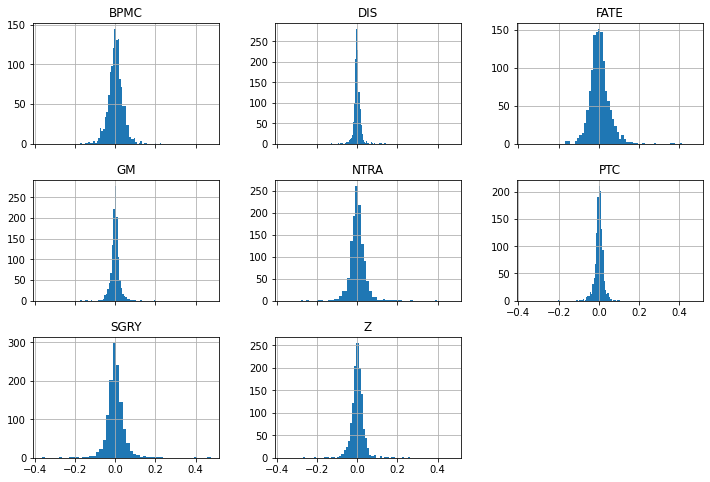

In [3]:
# Isolate the `Adj Close` values and transform the DataFrame
daily_close_px = data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
# Monthly percentage change 
daily_pct_change = daily_close_px.pct_change()
# distributions plot
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))
plt.show()

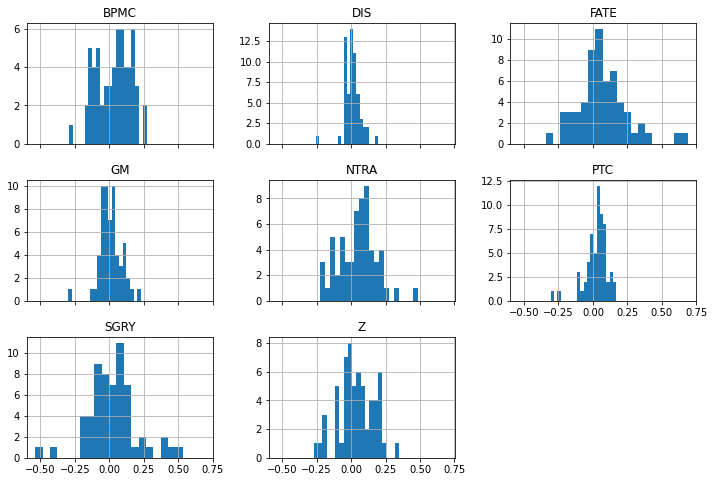

In [5]:
# Isolate the `Adj Close` values and transform the DataFrame
close_px = data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
mtly_close_px = close_px.resample('m').mean()
# print(mtly_close_px)

# Monthly percentage change 
mtly_return = mtly_close_px.pct_change()
# distributions plot
mtly_return.hist(bins=20, sharex=True, figsize=(12,8))
plt.show()

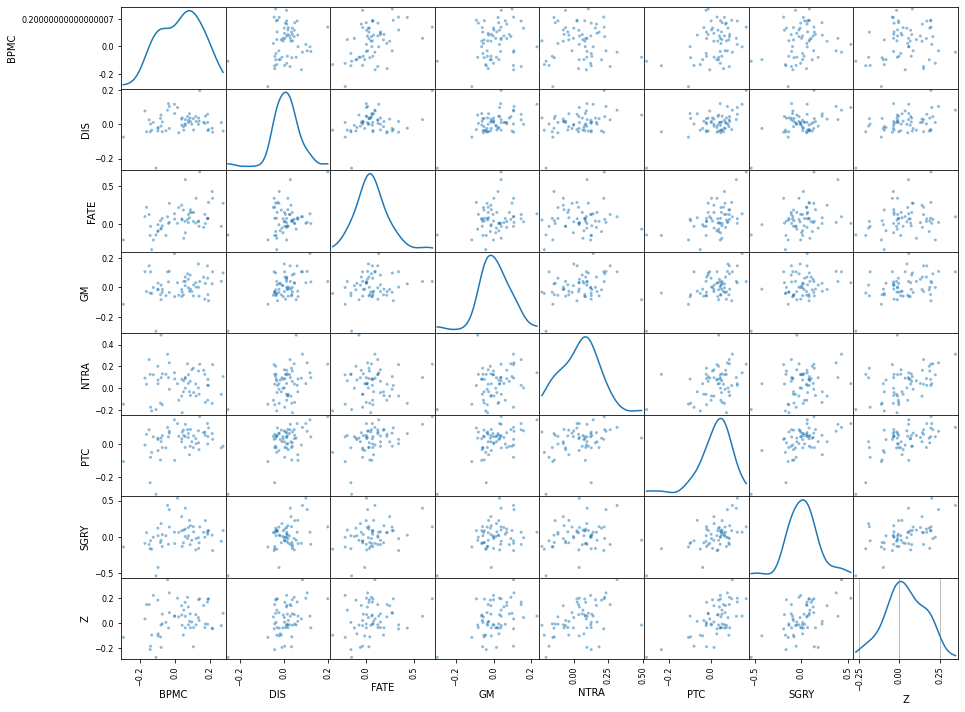

In [ ]:
# scatter matrix 
pd.plotting.scatter_matrix(mtly_return, diagonal='kde', figsize=(15,12))
plt.grid(True);plt.show()

In [22]:
bpmc = pd.DataFrame(mtly_close_px['BPMC'])

# The first component to extract is the trend.
bpmc['trend'] = bpmc.rolling(window=3, min_periods=3).mean()

# Seasonality will be cyclical patterns that occur in our time series once the data has had trend removed.
bpmc['detrend_a'] = bpmc['BPMC'] - bpmc['trend']
bpmc['detrend_b'] = bpmc['BPMC'] / bpmc['trend']

# To work out the seasonality we need to work out what the typical de-trended values are over a cycle. 
# Here I will calculate the mean value for the observations in Q1, Q2, Q3, and Q4.
bpmc['seasonal_a'] = bpmc['detrend_a'].mean()
bpmc['seasonal_b'] = bpmc['detrend_b'].mean()

# Now that we have our two components, we can calculate the residual in both situations and see which has the better fit.
bpmc['residual_a'] = bpmc['detrend_a'] - bpmc['seasonal_a']
bpmc['residual_b'] = bpmc['detrend_b'] - bpmc['seasonal_b']
bpmc


,BPMC,trend,detrend_a,detrend_b,seasonal_a,seasonal_b,residual_a,residual_b
Date,,,,,,,,
2015-12-31,26.340000,NaN,NaN,NaN,1.503415,1.028954,NaN,NaN
2016-01-31,18.631579,NaN,NaN,NaN,1.503415,1.028954,NaN,NaN
2016-02-29,16.164000,20.378526,-4.214526,0.793188,1.503415,1.028954,-5.717942,-0.235766
2016-03-31,17.324091,17.373223,-0.049132,0.997172,1.503415,1.028954,-1.552548,-0.031782
2016-04-30,18.656191,17.381427,1.274763,1.073341,1.503415,1.028954,-0.228652,0.044386
...,...,...,...,...,...,...,...,...
2020-08-31,74.731429,75.401310,-0.669881,0.991116,1.503415,1.028954,-2.173296,-0.037838
2020-09-30,79.083809,77.004170,2.079638,1.027007,1.503415,1.028954,0.576223,-0.001947
2020-10-31,100.730909,84.848716,15.882193,1.187182,1.503415,1.028954,14.378778,0.158228


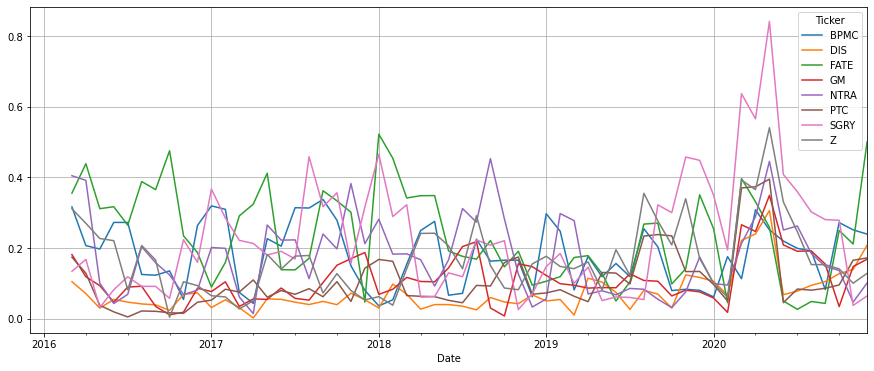

In [ ]:
import numpy as np

# Define the minumum of periods to consider 
min_periods = 3 
# Calculate the volatility
vol = mtly_return.rolling(min_periods).std() * np.sqrt(min_periods) 
# Plot the volatility
vol.plot(figsize=(15, 6)); plt.grid(True)
plt.show()

In [ ]:
from datetime import datetime
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
ls_key = 'Adj Close'
start = dt.datetime(2015,12,31)
end = dt.datetime(2020,12,31)
 
df = yf.download(tickers,start, end)
prices = df[[("Adj Close", s) for s in tickers]]
prices.columns = prices.columns.droplevel(level=0)
prices.index = pd.to_datetime(prices.index)

monthly_ret = prices.pct_change().resample('m').agg(lambda x: (x+1).prod() - 1)
monthly_ret

[*********************100%***********************]  8 of 8 completed


,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2015-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-31,-0.213763,-0.208333,-0.126917,-0.362018,-0.088123,-0.128492,-0.403189,-0.144961
2016-02-29,-0.184978,-0.210526,0.053659,-0.181395,-0.003131,-0.006748,0.102417,0.043904
2016-03-31,0.009901,0.410370,0.098611,0.022727,0.039678,0.080984,0.041546,0.072792
2016-04-30,0.228507,0.031513,0.013064,0.055556,0.039774,0.011772,-0.159003,0.099517
...,...,...,...,...,...,...,...,...
2020-08-31,0.250164,0.326739,0.253985,0.164055,0.127672,0.190438,0.058076,0.068373
2020-09-30,0.147197,0.133888,0.184585,0.098077,-0.059073,-0.001350,0.197210,-0.095066
2020-10-31,-0.003653,-0.068937,-0.127670,0.110833,-0.022808,0.166948,0.103344,0.014023


In [ ]:
import numpy as np

past_11 = (monthly_ret + 1).rolling(11).apply(np.prod) - 1
past_11.head(11)

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# portfolio formation date
formation = dt.datetime(2016,12,31)
formation

datetime.datetime(2016, 12, 31, 0, 0)

In [ ]:
# 1 month prior to formation date
end_measurement = formation - MonthEnd(1)
end_measurement

Timestamp('2016-11-30 00:00:00')

In [ ]:
# 12 months return
ret_12 = past_11.loc[end_measurement]
ret_12 = ret_12.reset_index()
ret_12

,index,2016-11-30 00:00:00
0,SGRY,-0.280137
1,NTRA,0.111111
2,Z,0.529813
3,FATE,-0.127596
4,DIS,-0.049866
5,GM,0.053574
6,BPMC,0.115034
7,PTC,0.406584


## Rank

In [ ]:
ret_12['decile'] = pd.qcut(ret_12.iloc[:, 1], 10, labels=False, duplicates='drop')
ret_12

,index,2016-11-30 00:00:00,decile
0,SGRY,-0.280137,0
1,NTRA,0.111111,5
2,Z,0.529813,9
3,FATE,-0.127596,1
4,DIS,-0.049866,2
5,GM,0.053574,4
6,BPMC,0.115034,7
7,PTC,0.406584,8


In [ ]:
winners = ret_12[ret_12.decile >= 8]
losers = ret_12[ret_12.decile <= 1]

print('Winners:'); print(winners); print()
print('Losers:'), print(losers)

Winners:
  index  2016-11-30 00:00:00  decile
2     Z             0.529813       9
7   PTC             0.406584       8

Losers:
  index  2016-11-30 00:00:00  decile
0  SGRY            -0.280137       0
3  FATE            -0.127596       1


(None, None)

In [ ]:
winner_ret = monthly_ret.loc[formation + MonthEnd(1),
                             monthly_ret.columns.isin(winners['index'])]

loser_ret = monthly_ret.loc[formation + MonthEnd(1),
                             monthly_ret.columns.isin(losers['index'])]

momentum_profit = winner_ret.mean() - loser_ret.mean()
print(momentum_profit)

-0.07428603876819745


## Function to define momentun:

In [ ]:
def momentum(formation):
  end_measurement = formation - MonthEnd(1)
  ret_12 = past_11.loc[end_measurement]
  ret_12 = ret_12.reset_index()
  ret_12['decile'] = pd.qcut(ret_12.iloc[:, 1], 10, labels=False, duplicates='drop')
  winners = ret_12[ret_12.decile >= 8]
  losers = ret_12[ret_12.decile <= 1]
  winner_ret = monthly_ret.loc[formation + MonthEnd(1),
                             monthly_ret.columns.isin(winners['index'])]

  loser_ret = monthly_ret.loc[formation + MonthEnd(1),
                             monthly_ret.columns.isin(losers['index'])]
  momentum_profit = winner_ret.mean() - loser_ret.mean()
  return (momentum_profit)

momentum(formation)

-0.07428603876819745

In [ ]:
for i in range(12*10):
  print(formation + MonthEnd(i))

2016-12-31 00:00:00
2017-01-31 00:00:00
2017-02-28 00:00:00
2017-03-31 00:00:00
2017-04-30 00:00:00
2017-05-31 00:00:00
2017-06-30 00:00:00
2017-07-31 00:00:00
2017-08-31 00:00:00
2017-09-30 00:00:00
2017-10-31 00:00:00
2017-11-30 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-02-28 00:00:00
2018-03-31 00:00:00
2018-04-30 00:00:00
2018-05-31 00:00:00
2018-06-30 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-09-30 00:00:00
2018-10-31 00:00:00
2018-11-30 00:00:00
2018-12-31 00:00:00
2019-01-31 00:00:00
2019-02-28 00:00:00
2019-03-31 00:00:00
2019-04-30 00:00:00
2019-05-31 00:00:00
2019-06-30 00:00:00
2019-07-31 00:00:00
2019-08-31 00:00:00
2019-09-30 00:00:00
2019-10-31 00:00:00
2019-11-30 00:00:00
2019-12-31 00:00:00
2020-01-31 00:00:00
2020-02-29 00:00:00
2020-03-31 00:00:00
2020-04-30 00:00:00
2020-05-31 00:00:00
2020-06-30 00:00:00
2020-07-31 00:00:00
2020-08-31 00:00:00
2020-09-30 00:00:00
2020-10-31 00:00:00
2020-11-30 00:00:00
2020-12-31 00:00:00
2021-01-31 00:00:00


In [ ]:
profits = []
dates = []

for i in range(12*4):
  profits.append(momentum(formation + MonthEnd(i)))
  dates.append(formation + MonthEnd(i))

dataframe = pd.DataFrame(profits[1:])
dataframe

,0
0,-0.109790
1,0.056119
2,0.066900
3,-0.280368
4,0.136062
5,0.069655
6,-0.053435
7,0.097289
8,0.124023
9,-0.017686


In [ ]:
dates

[Timestamp('2016-12-31 00:00:00'),
 Timestamp('2017-01-31 00:00:00'),
 Timestamp('2017-02-28 00:00:00'),
 Timestamp('2017-03-31 00:00:00'),
 Timestamp('2017-04-30 00:00:00'),
 Timestamp('2017-05-31 00:00:00'),
 Timestamp('2017-06-30 00:00:00'),
 Timestamp('2017-07-31 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timestamp('2017-09-30 00:00:00'),
 Timestamp('2017-10-31 00:00:00'),
 Timestamp('2017-11-30 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-28 00:00:00'),
 Timestamp('2018-03-31 00:00:00'),
 Timestamp('2018-04-30 00:00:00'),
 Timestamp('2018-05-31 00:00:00'),
 Timestamp('2018-06-30 00:00:00'),
 Timestamp('2018-07-31 00:00:00'),
 Timestamp('2018-08-31 00:00:00'),
 Timestamp('2018-09-30 00:00:00'),
 Timestamp('2018-10-31 00:00:00'),
 Timestamp('2018-11-30 00:00:00'),
 Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-31 00:00:00'),
 Timestamp('2019-02-28 00:00:00'),
 Timestamp('2019-03-31 00:00:00'),
 Timestamp('2019-04-

## Benchmarking against SP500

In [ ]:
SP = yf.download('^GSPC', start=dates[0], end=dates[-1])
SP = SP['Adj Close']
SP_mtnhly_ret = SP.pct_change().resample('m').agg(lambda x: (x+1).prod() -1)
print(SP_mtnhly_ret)                                                  

[*********************100%***********************]  1 of 1 completed
Date
2017-01-31    0.009319
2017-02-28    0.037198
2017-03-31   -0.000389
2017-04-30    0.009091
2017-05-31    0.011576
2017-06-30    0.004814
2017-07-31    0.019349
2017-08-31    0.000546
2017-09-30    0.019303
2017-10-31    0.022188
2017-11-30    0.028083
2017-12-31    0.009832
2018-01-31    0.056179
2018-02-28   -0.038947
2018-03-31   -0.026884
2018-04-30    0.002719
2018-05-31    0.021608
2018-06-30    0.004842
2018-07-31    0.036022
2018-08-31    0.030263
2018-09-30    0.004294
2018-10-31   -0.069403
2018-11-30    0.017859
2018-12-31   -0.091777
2019-01-31    0.078684
2019-02-28    0.029729
2019-03-31    0.017924
2019-04-30    0.039313
2019-05-31   -0.065778
2019-06-30    0.068930
2019-07-31    0.013128
2019-08-31   -0.018092
2019-09-30    0.017181
2019-10-31    0.020432
2019-11-30    0.034047
2019-12-31    0.028590
2020-01-31   -0.001628
2020-02-29   -0.084110
2020-03-31   -0.125119
2020-04-30    0.126844
2020-0

In [ ]:
dataframe['SP500'] = SP_mtnhly_ret.values
print(dataframe)

           0     SP500
0  -0.109790  0.009319
1   0.056119  0.037198
2   0.066900 -0.000389
3  -0.280368  0.009091
4   0.136062  0.011576
5   0.069655  0.004814
6  -0.053435  0.019349
7   0.097289  0.000546
8   0.124023  0.019303
9  -0.017686  0.022188
10  0.091059  0.028083
11  0.047898  0.009832
12  0.181965  0.056179
13 -0.064743 -0.038947
14 -0.030186 -0.026884
15  0.086519  0.002719
16 -0.089998  0.021608
17 -0.190103  0.004842
18  0.255918  0.036022
19  0.083815  0.030263
20 -0.091524  0.004294
21  0.038217 -0.069403
22 -0.094545  0.017859
23 -0.147416 -0.091777
24  0.052961  0.078684
25  0.344052  0.029729
26 -0.019294  0.017924
27  0.133300  0.039313
28  0.114555 -0.065778
29  0.051190  0.068930
30 -0.013750  0.013128
31 -0.139138 -0.018092
32  0.056721  0.017181
33 -0.471622  0.020432
34 -0.107001  0.034047
35 -0.095486  0.028590
36  0.055471 -0.001628
37 -0.110805 -0.084110
38  0.167949 -0.125119
39  0.035610  0.126844
40  0.010010  0.045282
41  0.154595  0.018388
42  0.12114

In [ ]:
dataframe['excess'] = dataframe.iloc[:,0] - dataframe.iloc[:,1]
print(dataframe)

           0     SP500    excess
0  -0.109790  0.009319 -0.119108
1   0.056119  0.037198  0.018921
2   0.066900 -0.000389  0.067289
3  -0.280368  0.009091 -0.289459
4   0.136062  0.011576  0.124486
5   0.069655  0.004814  0.064841
6  -0.053435  0.019349 -0.072784
7   0.097289  0.000546  0.096743
8   0.124023  0.019303  0.104720
9  -0.017686  0.022188 -0.039874
10  0.091059  0.028083  0.062977
11  0.047898  0.009832  0.038066
12  0.181965  0.056179  0.125787
13 -0.064743 -0.038947 -0.025796
14 -0.030186 -0.026884 -0.003302
15  0.086519  0.002719  0.083800
16 -0.089998  0.021608 -0.111606
17 -0.190103  0.004842 -0.194945
18  0.255918  0.036022  0.219897
19  0.083815  0.030263  0.053552
20 -0.091524  0.004294 -0.095818
21  0.038217 -0.069403  0.107620
22 -0.094545  0.017859 -0.112404
23 -0.147416 -0.091777 -0.055639
24  0.052961  0.078684 -0.025723
25  0.344052  0.029729  0.314323
26 -0.019294  0.017924 -0.037219
27  0.133300  0.039313  0.093987
28  0.114555 -0.065778  0.180333
29  0.0511

In [ ]:
dataframe['outperformed'] = ['YES' if i > 0 else "NO" for i in dataframe.excess]
print(dataframe)

           0     SP500    excess outperformed
0  -0.109790  0.009319 -0.119108           NO
1   0.056119  0.037198  0.018921          YES
2   0.066900 -0.000389  0.067289          YES
3  -0.280368  0.009091 -0.289459           NO
4   0.136062  0.011576  0.124486          YES
5   0.069655  0.004814  0.064841          YES
6  -0.053435  0.019349 -0.072784           NO
7   0.097289  0.000546  0.096743          YES
8   0.124023  0.019303  0.104720          YES
9  -0.017686  0.022188 -0.039874           NO
10  0.091059  0.028083  0.062977          YES
11  0.047898  0.009832  0.038066          YES
12  0.181965  0.056179  0.125787          YES
13 -0.064743 -0.038947 -0.025796           NO
14 -0.030186 -0.026884 -0.003302           NO
15  0.086519  0.002719  0.083800          YES
16 -0.089998  0.021608 -0.111606           NO
17 -0.190103  0.004842 -0.194945           NO
18  0.255918  0.036022  0.219897          YES
19  0.083815  0.030263  0.053552          YES
20 -0.091524  0.004294 -0.095818  

In [ ]:
pd.value_counts(dataframe.outperformed)

NO     24
YES    23
Name: outperformed, dtype: int64